In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
X_pca=pd.read_excel(r"PCA_data.xlsx")
df=pd.read_excel(r'imp_features.xlsx')

Params: {'metric': 'euclidean', 'min_cluster_size': 5, 'min_samples': 5},Num_Clusters:44, Silhouette Score: -0.13468381216896408, Davies-Bouldin Index: 1.3931264808696036, Calinski-Harabasz Index: 14.457327691653921
Params: {'metric': 'euclidean', 'min_cluster_size': 5, 'min_samples': 10},Num_Clusters:24, Silhouette Score: -0.19262068481153105, Davies-Bouldin Index: 1.4145224263827618, Calinski-Harabasz Index: 15.079392698888203
Params: {'metric': 'euclidean', 'min_cluster_size': 5, 'min_samples': 15},Num_Clusters:12, Silhouette Score: -0.1350645558956095, Davies-Bouldin Index: 1.4162511336360668, Calinski-Harabasz Index: 19.86729211630316
Params: {'metric': 'euclidean', 'min_cluster_size': 5, 'min_samples': 20},Num_Clusters:10, Silhouette Score: -0.1272739221456282, Davies-Bouldin Index: 1.50717097667935, Calinski-Harabasz Index: 28.891400637433147
Params: {'metric': 'euclidean', 'min_cluster_size': 10, 'min_samples': 5},Num_Clusters:29, Silhouette Score: -0.12139674543503809, Davies-

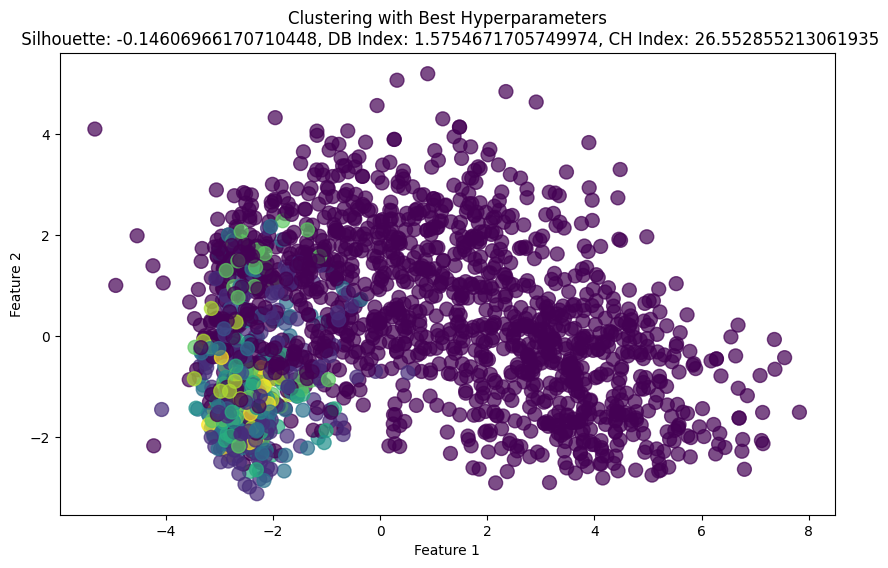

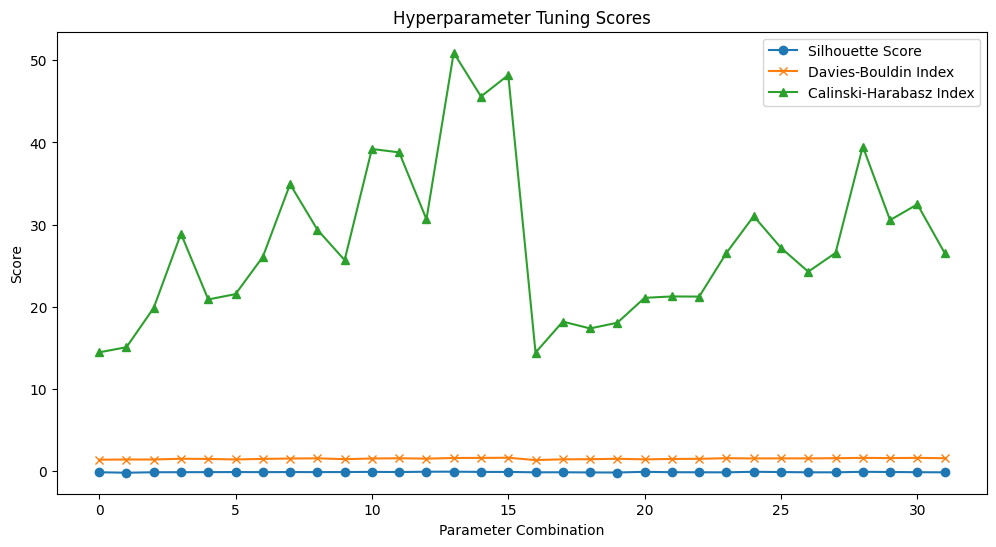

In [3]:
import hdbscan
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# Assuming 'X' is your feature matrix

# Define the parameter grid
param_grid = {
    'min_cluster_size': [5, 10, 15, 20],  # Range for min_cluster_size
    'min_samples': [5, 10, 15, 20],       # Range for min_samples
    'metric': ['euclidean', 'manhattan'],  # Distance metrics to try
}

best_score = -1
best_params = None
best_model = None

# Store results for plotting
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
results=[]

# Iterate over all parameter combinations
for params in ParameterGrid(param_grid):
    model = hdbscan.HDBSCAN(**params)
    model.fit(X_pca)  # Fit the model
    
    # Only evaluate the scores if the clustering produces more than one cluster
    if len(np.unique(model.labels_)) > 1:
        # Silhouette Score
        try:
            silhouette = silhouette_score(X_pca, model.labels_)
        except ValueError:  # Handle cases where silhouette score is undefined
            silhouette = -1
        labels=model.labels_
        # Davies-Bouldin Index
        db_index = davies_bouldin_score(X_pca, model.labels_)
        
        # Calinski-Harabasz Index
        ch_index = calinski_harabasz_score(X_pca, model.labels_)
        
        # Append the scores for comparison
        silhouette_scores.append(silhouette)
        davies_bouldin_scores.append(db_index)
        calinski_harabasz_scores.append(ch_index)

        unique, frequency = np.unique(model.labels_, 
                              return_counts = True)


        results.append((unique, frequency,params,len(set( model.labels_)),silhouette,db_index,ch_index))
        
        print(f"Params: {params},Num_Clusters:{len(set( model.labels_))}, Silhouette Score: {silhouette}, Davies-Bouldin Index: {db_index}, Calinski-Harabasz Index: {ch_index}")
        
        # Track the best model based on a weighted score (you can use your own weighting logic)
        weighted_score = silhouette * 0.4 - db_index * 0.3 + ch_index * 0.3
        
        if weighted_score > best_score:
            best_score = weighted_score
            best_params = params
            best_model = model
results_df = pd.DataFrame(
    results, columns=['unique','frequency','params','Num_Clusters','Silhouette_Score', 'DBI', 'CH']
)

# Best configurations
best_silhouette = results_df.loc[results_df['Silhouette_Score'].idxmax()]
best_dbi = results_df.loc[results_df['DBI'].idxmin()]
best_ch = results_df.loc[results_df['CH'].idxmax()]

print("\nBest model based on Silhouette Score:")
print(best_silhouette)
print("\nBest model based on Davies-Bouldin Index:")
print(best_dbi)
print("\nBest model based on Calinski-Harabasz Index:")
print(best_ch)

# Visualize the clustering result for the best model
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[0], X_pca[1], c=best_model.labels_, cmap='viridis', s=100, alpha=0.7)
plt.title(f"Clustering with Best Hyperparameters\n Silhouette: {silhouette_scores[-1]}, DB Index: {davies_bouldin_scores[-1]}, CH Index: {calinski_harabasz_scores[-1]}")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Plot the scores across different parameter combinations
plt.figure(figsize=(12, 6))
plt.plot(range(len(silhouette_scores)), silhouette_scores, label='Silhouette Score', marker='o')
plt.plot(range(len(davies_bouldin_scores)), davies_bouldin_scores, label='Davies-Bouldin Index', marker='x')
plt.plot(range(len(calinski_harabasz_scores)), calinski_harabasz_scores, label='Calinski-Harabasz Index', marker='^')
plt.title('Hyperparameter Tuning Scores')
plt.xlabel('Parameter Combination')
plt.ylabel('Score')
plt.legend()
plt.show()


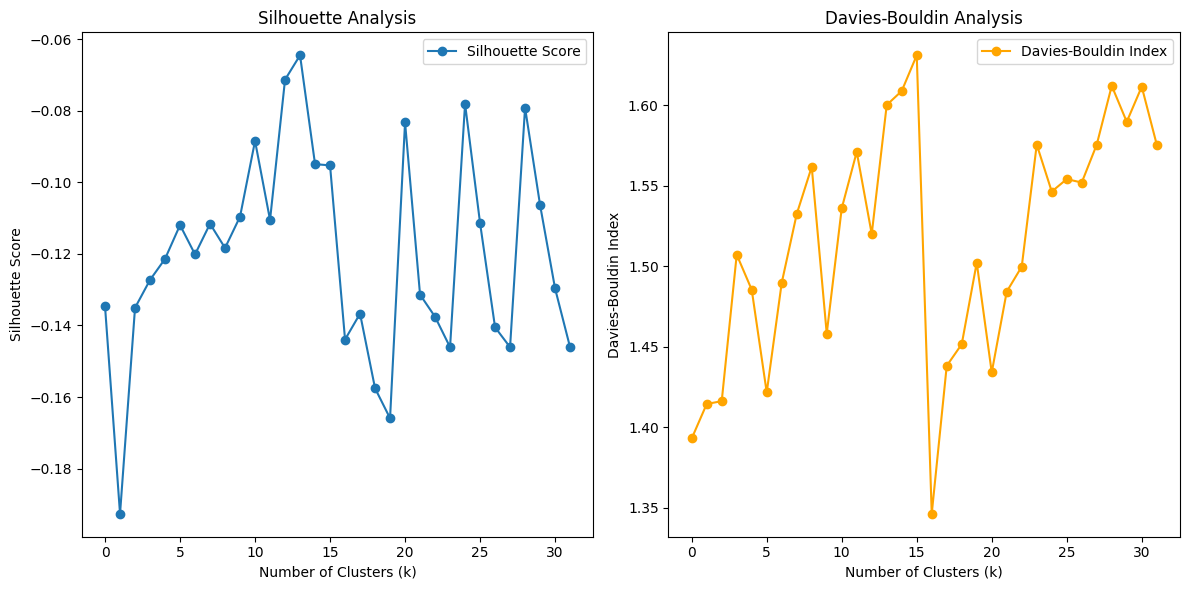

In [4]:
results_df['index'] = range(32)
# Plot Silhouette Scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(results_df['index'], results_df['Silhouette_Score'], marker='o', label='Silhouette Score')
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()

# Plot Davies-Bouldin Index
plt.subplot(1, 2, 2)
plt.plot(results_df['index'], results_df['DBI'], marker='o', color='orange', label='Davies-Bouldin Index')
plt.title('Davies-Bouldin Analysis')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
results_df

,unique,frequency,params,Num_Clusters,Silhouette_Score,DBI,CH,index
0,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[1374, 13, 5, 7, 5, 12, 6, 9, 20, 49, 5, 21, 1...","{'metric': 'euclidean', 'min_cluster_size': 5,...",44,-0.134684,1.393126,14.457328,0
1,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[1598, 7, 5, 18, 16, 10, 41, 15, 23, 7, 17, 13...","{'metric': 'euclidean', 'min_cluster_size': 5,...",24,-0.192621,1.414522,15.079393,1
2,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1725, 6, 14, 39, 17, 8, 49, 19, 43, 40, 25, 39]","{'metric': 'euclidean', 'min_cluster_size': 5,...",12,-0.135065,1.416251,19.867292,2
3,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]","[1657, 141, 11, 73, 8, 9, 36, 38, 36, 15]","{'metric': 'euclidean', 'min_cluster_size': 5,...",10,-0.127274,1.507171,28.891401,3
4,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[1379, 13, 27, 20, 49, 26, 16, 18, 31, 14, 11,...","{'metric': 'euclidean', 'min_cluster_size': 10...",29,-0.121397,1.485410,20.889575,4
5,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[1594, 18, 16, 10, 41, 15, 23, 17, 13, 42, 31,...","{'metric': 'euclidean', 'min_cluster_size': 10...",17,-0.111955,1.421672,21.542984,5
6,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]","[1696, 14, 39, 17, 92, 19, 43, 40, 25, 39]","{'metric': 'euclidean', 'min_cluster_size': 10...",10,-0.120141,1.489698,26.071851,6
7,"[-1, 0, 1, 2, 3, 4, 5, 6]","[1674, 141, 11, 73, 36, 38, 36, 15]","{'metric': 'euclidean', 'min_cluster_size': 10...",8,-0.111590,1.532391,34.918310,7
8,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[1396, 27, 20, 49, 26, 16, 18, 31, 48, 20, 69,...","{'metric': 'euclidean', 'min_cluster_size': 15...",19,-0.118348,1.561669,29.384275,8
9,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1599, 18, 16, 56, 15, 23, 17, 58, 31, 55, 46,...","{'metric': 'euclidean', 'min_cluster_size': 15...",14,-0.109601,1.458200,25.676783,9


In [6]:
best_silhouette.params

{'metric': 'euclidean', 'min_cluster_size': 20, 'min_samples': 10}

In [7]:
best_ch.params

{'metric': 'euclidean', 'min_cluster_size': 20, 'min_samples': 10}

In [8]:
best_dbi.params

{'metric': 'manhattan', 'min_cluster_size': 5, 'min_samples': 5}

# **best Silhouette Score**

In [9]:
# Apply HDBSCAN clustering
Sil_model = hdbscan.HDBSCAN(metric= 'manhattan', min_cluster_size= 20, min_samples= 15)
sil_labels = Sil_model.fit_predict(X_pca)

# Evaluate clustering quality

print(f"The average silhouette score for HDBSCAN is: {silhouette_score(X_pca, sil_labels)}")
print(f"The Davies-Bouldin Index for HDBSCAN is: {davies_bouldin_score(X_pca, sil_labels)}")
print(f"The Calinski-Harabasz Index for HDBSCAN is: {calinski_harabasz_score(X_pca, sil_labels)}")

The average silhouette score for HDBSCAN is: -0.12964999103398978
The Davies-Bouldin Index for HDBSCAN is: 1.6114088456869073
The Calinski-Harabasz Index for HDBSCAN is: 32.46574320630181


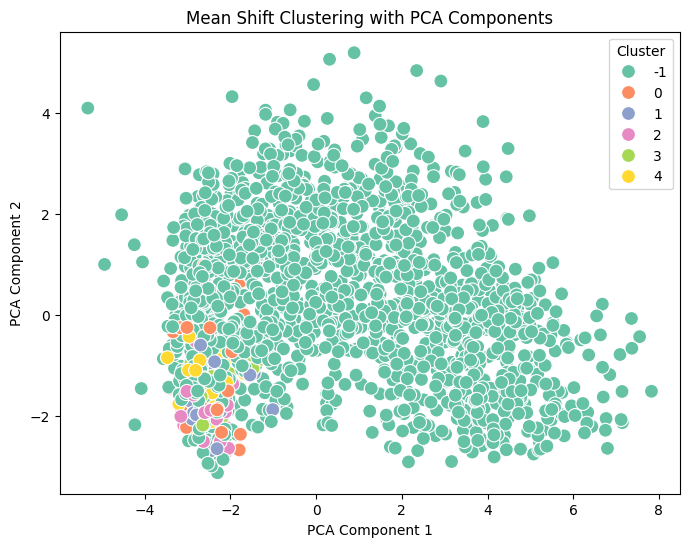

In [10]:
# Visualize the HDBSCAN clusters in the PCA space
plt.figure(figsize=(8, 6))

# Scatter plot: Points labeled by their cluster assignment
sns.scatterplot(x=X_pca[0], y=X_pca[1], hue=sil_labels, palette='Set2', s=100)

plt.title('Mean Shift Clustering with PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster")
plt.show()

# **davies bouldin index**

In [11]:
# Apply HDBSCAN clustering
dbi_model = hdbscan.HDBSCAN(metric= 'euclidean', min_cluster_size= 5, min_samples= 5)
dbi_labels = dbi_model.fit_predict(X_pca)

# Evaluate clustering quality

print(f"The average silhouette score for HDBSCAN is: {silhouette_score(X_pca, dbi_labels)}")
print(f"The Davies-Bouldin Index for HDBSCAN is: {davies_bouldin_score(X_pca, dbi_labels)}")
print(f"The Calinski-Harabasz Index for HDBSCAN is: {calinski_harabasz_score(X_pca, dbi_labels)}")

The average silhouette score for HDBSCAN is: -0.13468381216896408
The Davies-Bouldin Index for HDBSCAN is: 1.3931264808696036
The Calinski-Harabasz Index for HDBSCAN is: 14.457327691653921


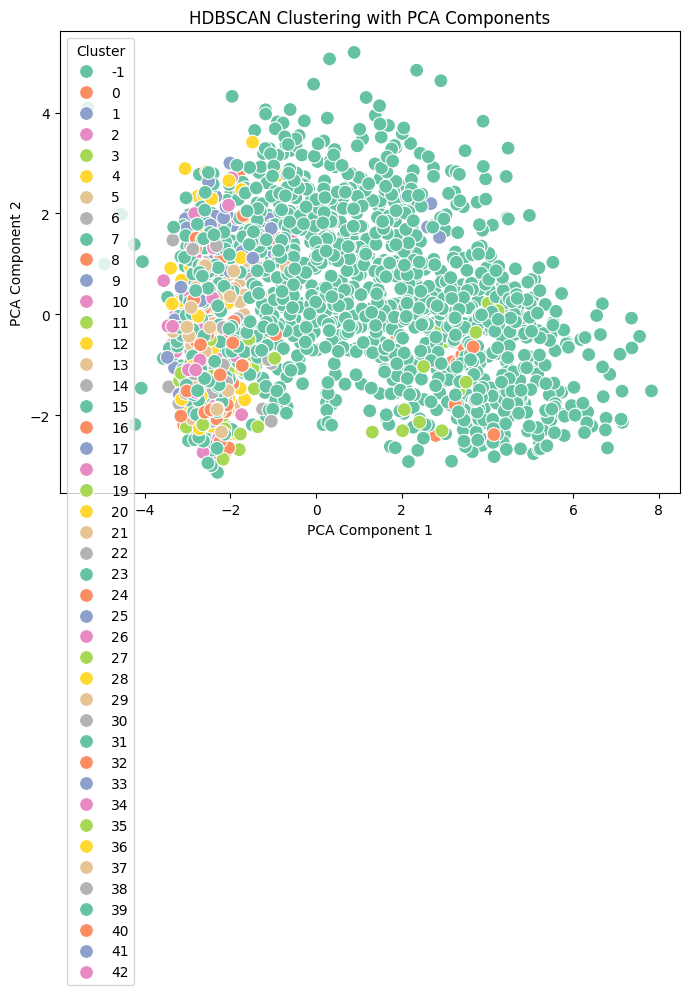

In [12]:
# Visualize the HDBSCAN Clustering in the PCA space
plt.figure(figsize=(8, 6))

# Scatter plot: Points labeled by their cluster assignment
sns.scatterplot(x=X_pca[0], y=X_pca[1], hue=dbi_labels, palette='Set2', s=100)

plt.title('HDBSCAN Clustering with PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster")
plt.show()

# **calinski_harabasz_index**

In [13]:
# Apply HDBSCAN clustering
Ch_model = hdbscan.HDBSCAN(metric='manhattan', min_cluster_size= 20, min_samples= 15)
ch_labels = Ch_model.fit_predict(X_pca)

# Evaluate clustering quality

print(f"The average silhouette score for HDBSCAN is: {silhouette_score(X_pca, ch_labels)}")
print(f"The Davies-Bouldin Index for HDBSCAN is: {davies_bouldin_score(X_pca, ch_labels)}")
print(f"The Calinski-Harabasz Index for HDBSCAN is: {calinski_harabasz_score(X_pca, ch_labels)}")

The average silhouette score for HDBSCAN is: -0.12964999103398978
The Davies-Bouldin Index for HDBSCAN is: 1.6114088456869073
The Calinski-Harabasz Index for HDBSCAN is: 32.46574320630181


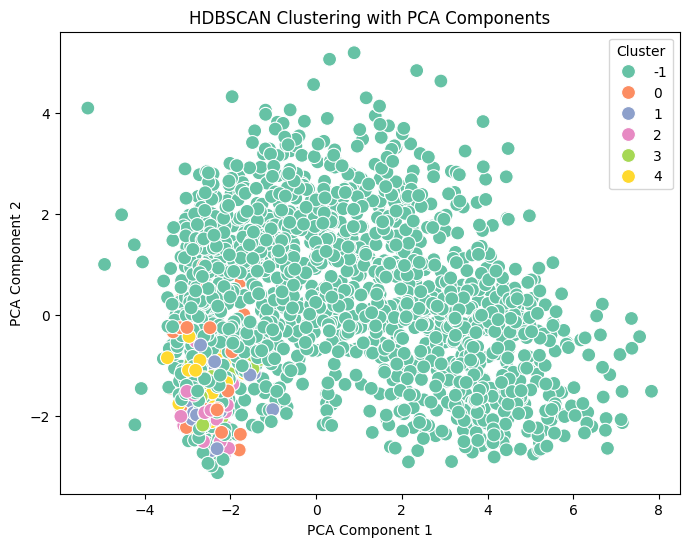

In [14]:
# Visualize the HDBSCAN Clustering in the PCA space
plt.figure(figsize=(8, 6))

# Scatter plot: Points labeled by their cluster assignment
sns.scatterplot(x=X_pca[0], y=X_pca[1], hue=ch_labels, palette='Set2', s=100)

plt.title('HDBSCAN Clustering with PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster")
plt.show()

In [15]:
results_df

,unique,frequency,params,Num_Clusters,Silhouette_Score,DBI,CH,index
0,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[1374, 13, 5, 7, 5, 12, 6, 9, 20, 49, 5, 21, 1...","{'metric': 'euclidean', 'min_cluster_size': 5,...",44,-0.134684,1.393126,14.457328,0
1,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[1598, 7, 5, 18, 16, 10, 41, 15, 23, 7, 17, 13...","{'metric': 'euclidean', 'min_cluster_size': 5,...",24,-0.192621,1.414522,15.079393,1
2,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1725, 6, 14, 39, 17, 8, 49, 19, 43, 40, 25, 39]","{'metric': 'euclidean', 'min_cluster_size': 5,...",12,-0.135065,1.416251,19.867292,2
3,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]","[1657, 141, 11, 73, 8, 9, 36, 38, 36, 15]","{'metric': 'euclidean', 'min_cluster_size': 5,...",10,-0.127274,1.507171,28.891401,3
4,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[1379, 13, 27, 20, 49, 26, 16, 18, 31, 14, 11,...","{'metric': 'euclidean', 'min_cluster_size': 10...",29,-0.121397,1.485410,20.889575,4
5,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[1594, 18, 16, 10, 41, 15, 23, 17, 13, 42, 31,...","{'metric': 'euclidean', 'min_cluster_size': 10...",17,-0.111955,1.421672,21.542984,5
6,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]","[1696, 14, 39, 17, 92, 19, 43, 40, 25, 39]","{'metric': 'euclidean', 'min_cluster_size': 10...",10,-0.120141,1.489698,26.071851,6
7,"[-1, 0, 1, 2, 3, 4, 5, 6]","[1674, 141, 11, 73, 36, 38, 36, 15]","{'metric': 'euclidean', 'min_cluster_size': 10...",8,-0.111590,1.532391,34.918310,7
8,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[1396, 27, 20, 49, 26, 16, 18, 31, 48, 20, 69,...","{'metric': 'euclidean', 'min_cluster_size': 15...",19,-0.118348,1.561669,29.384275,8
9,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1599, 18, 16, 56, 15, 23, 17, 58, 31, 55, 46,...","{'metric': 'euclidean', 'min_cluster_size': 15...",14,-0.109601,1.458200,25.676783,9


****

In [16]:
# Log best Silhouette Score model
# Set up MLflow experiment
mlflow.set_experiment("HDBSCAN Clustering Tuning")
with mlflow.start_run(run_name="Best_Silhouette_HDBSCAN"):
    mlflow.log_params({'n_clusters': best_silhouette['Num_Clusters']})
    mlflow.log_metrics({
        'Silhouette_Score': best_silhouette['Silhouette_Score'],
        'davies_bouldin_index': best_silhouette['DBI'],
        'calinski_harabasz_index': best_silhouette['CH']
    })

# Log best Davies-Bouldin Index model
with mlflow.start_run(run_name="Best_DBI_HDBSCAN"):
    mlflow.log_params({'n_clusters': best_dbi['Num_Clusters']})
    mlflow.log_metrics({
        'Silhouette_Score': best_dbi['Silhouette_Score'],
        'davies_bouldin_index': best_dbi['DBI'],
        'calinski_harabasz_index': best_dbi['CH']
    })

# Log best Calinski-Harabasz Index model
with mlflow.start_run(run_name="Best_CH_HDBSCAN"):
    mlflow.log_params({'n_clusters': best_ch['Num_Clusters']})
    mlflow.log_metrics({
        'Silhouette_Score': best_ch['Silhouette_Score'],
        'davies_bouldin_index': best_ch['DBI'],
        'calinski_harabasz_index': best_ch['CH']
    })
